# **Imports**

In [1]:
# Import files
import os as osx 
import json
from IPython.display import FileLink

#import Kaggle module
import kagglehub

# Imports
import numpy as npx
import pandas as pdx
import random as randomx
from sklearn.metrics import (
    accuracy_score as accx,
    f1_score as f1sx,
    precision_score as psx,
    recall_score as rsx,
    cohen_kappa_score as cksx,
    classification_report as crx,
    confusion_matrix as cmx,
    roc_auc_score as rocx,
    roc_curve as roccx
)
import math

# Visualization
import seaborn as snsx
from tqdm import tqdm
import plotly.express as pxx
import matplotlib.pyplot as pltx
from PIL import Image as Img
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing import image as imgs
# Image preprocessing utilities — loading, resizing, converting images to arrays.

# Tensorflow
import tensorflow as tfx
from tensorflow import keras as kx
from tensorflow.keras import callbacks as cbx, layers as lx, Model as mdl
from tensorflow.keras.preprocessing.image import ImageDataGenerator as idg
from tensorflow.keras.callbacks import ModelCheckpoint as mcpx
from tensorflow.keras.callbacks import  EarlyStopping as esx
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image as img
from tensorflow.keras.layers import Input as inpt , GlobalAveragePooling2D as gapx, Dropout as drpout, Dense as dnse, BatchNormalization as bnx
from tensorflow.keras.regularizers import l2
# Notebook magic
%matplotlib inline

2025-06-19 04:31:48.970165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750307509.133073      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750307509.182642      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# to avoid unnecessary warinings
osx.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# **Dataset**

In [3]:
vipool_nw_plnt_diseases_dtst_pth = kagglehub.dataset_download('vipoooool/new-plant-diseases-dataset')

print('Data source import complete.')


Data source import complete.


# **Config**

In [4]:
class config:
    # Batch Size
    trn_btch_sze = 32
    tst_btch_sze = 16
    # save and load paths
    bst_mbnet_mdl='/kaggle/input/leaf_diseasemobilenet/tensorflow2/default/1/best_model.keras'
    mbnet_categories='/kaggle/input/leaf_diseasemobilenet/tensorflow2/default/1/mbnet_categories.json'
    mbnet_mdl='/kaggle/input/leaf_diseasemobilenet/tensorflow2/default/1/mbnet_plant_disease.keras'
    mbnet_hisx='/kaggle/input/leaf_diseasemobilenet/tensorflow2/default/1/mbnet_history.json'
    enble_trning=False
    #dataset path
    dtst_root = "/kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"
    trn_dir = osx.path.join(dtst_root, "train")
    tst_dir = osx.path.join(dtst_root, "valid")
    rl_timex_dir='/kaggle/input/new-plant-diseases-dataset/test/test'
    # number of epochs for the model
    epochs=14

# **Augmentation**

For Training 

In [5]:
# Define augmentations for train dataset and read the images
img_sze = 224
trn_aug = idg(
    # Rescale
    rescale=1/255.0,
    # Filling for W/H shift
    fill_mode="nearest",
    # Width and Height shift
    width_shift_range=0.2,
    height_shift_range=0.2,
    # Random zooms
    zoom_range=0.2,
    # Random Shearing aug
    shear_range=0.2
)

# Read data from directory
trn_dta = trn_aug.flow_from_directory(
    config.trn_dir,
    target_size=(img_sze, img_sze),
    batch_size=config.trn_btch_sze,
    class_mode="categorical"
)

Found 70295 images belonging to 38 classes.


In [6]:
cts = list(trn_dta.class_indices.keys())

For Testing

In [7]:
# Define a shared ImageDataGenerator with validation_split
dta_aug = idg(
    rescale=1/255.0,
    fill_mode="nearest",
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    validation_split=0.5, # 50% for validation
)

# Training data (50%)
tst_dta = dta_aug.flow_from_directory(
    config.tst_dir,
    target_size=(img_sze, img_sze),
    batch_size=config.tst_btch_sze,
    class_mode="categorical",
    subset='training',
    shuffle=False,
    seed=42
)

# Validation data (50%)
val_dta = dta_aug.flow_from_directory(
    config.tst_dir,
    target_size=(img_sze, img_sze),
    batch_size=config.tst_btch_sze,
    class_mode="categorical",
    subset='validation',
    shuffle=False,
    seed=42
)


Found 8795 images belonging to 38 classes.
Found 8777 images belonging to 38 classes.


Exploratory Data Analysis

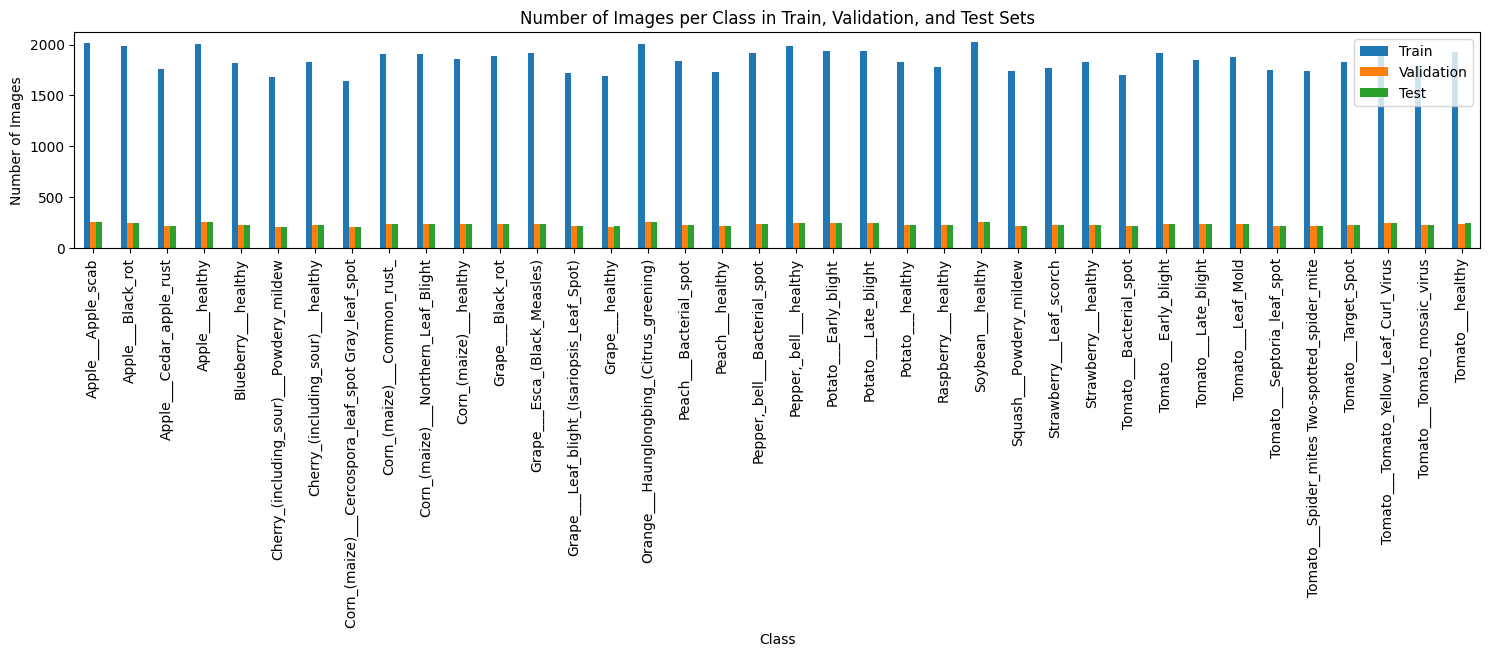

In [8]:
# Helper function to get class counts from a generator
def get_clss_cnts_frm_gnrtr(gnrtr):
    cnts = dict.fromkeys(gnrtr.class_indices.keys(), 0)
    lbls = gnrtr.classes  # This is a numpy array of all class indices
    for clss_idx in lbls:
        clss_nme = list(gnrtr.class_indices.keys())[list(gnrtr.class_indices.values()).index(clss_idx)]
        cnts[clss_nme] += 1
    return cnts

# Get counts from generators
trn_clss_cnts = get_clss_cnts_frm_gnrtr(trn_dta)
val_clss_cnts   = get_clss_cnts_frm_gnrtr(val_dta)
tst_clss_cnts  = get_clss_cnts_frm_gnrtr(tst_dta)

# All unique classes
all_clsses = sorted(set(trn_clss_cnts.keys()) |
                     set(val_clss_cnts.keys()) |
                     set(tst_clss_cnts.keys()))

# Prepare data for DataFrame
trn_cnts = [trn_clss_cnts.get(cls, 0) for cls in all_clsses]
val_cnts   = [val_clss_cnts.get(cls, 0) for cls in all_clsses]
tst_cnts  = [tst_clss_cnts.get(cls, 0) for cls in all_clsses]

# Create DataFrame
dfx = pdx.DataFrame({
    'Class': all_clsses,
    'Train': trn_cnts,
    'Validation': val_cnts,
    'Test': tst_cnts
})

# Plotting
axx = dfx.plot(x='Class', y=['Train', 'Validation', 'Test'], kind='bar', figsize=(15, 7))
pltx.title('Number of Images per Class in Train, Validation, and Test Sets')
pltx.xlabel('Class')
pltx.ylabel('Number of Images')
pltx.xticks(rotation=90)
pltx.tight_layout()
pltx.subplots_adjust(top=0.9)
pltx.show()


In [9]:
# === 1. Class name parser ===
def prse_clss_nme(clss_nme):
    prts = clss_nme.split('___')
    plnt = prts[0]
    diseasex = prts[1].replace('_', ' ')
    return plnt, diseasex

# === 2. Helper function to count class samples from generator ===
def get_clss_cnts(gnrtr):
    cnts = dict.fromkeys(gnrtr.class_indices.keys(), 0)
    lbls = gnrtr.classes  # numpy array of class indices
    for clss_idx in lbls:
        clss_nme = list(gnrtr.class_indices.keys())[list(gnrtr.class_indices.values()).index(clss_idx)]
        cnts[clss_nme] += 1
    return cnts

# === 3. Get class counts from your generators ===
trn_clss_cnts = get_clss_cnts(trn_dta)
val_clss_cnts = get_clss_cnts(val_dta)
tst_clss_cnts = get_clss_cnts(tst_dta)

# === 4. Combine into total counts for sunburst ===
cmbined_clss_cnts = {}
for cls in trn_clss_cnts.keys():
    totl = (
        trn_clss_cnts.get(cls, 0) +
        val_clss_cnts.get(cls, 0) +
        tst_clss_cnts.get(cls, 0)
    )
    cmbined_clss_cnts[cls] = totl

# === 5. Prepare data for sunburst ===
dta_for_snbrst = []
totl_imgs = sum(cmbined_clss_cnts.values())

for cls, cnt in cmbined_clss_cnts.items():
    plnt, diseasex = prse_clss_nme(cls)
    prcntg = (cnt / totl_imgs) * 100
    dta_for_snbrst.append({
        'Plant': plnt,
        'Disease': diseasex,
        'Count': cnt,
        'Percentage': prcntg
    })

dfx = pdx.DataFrame(dta_for_snbrst)

# === 6. Create sunburst chart ===
figx = pxx.sunburst(
    dfx,
    path=['Plant', 'Disease'],
    values='Percentage',
    title='Distribution of Plant Species and Diseases',
    color='Percentage',
    color_continuous_scale='Tealgrn'
)

# === 7. Customize chart ===
figx.update_traces(
    textinfo='label+percent entry',
    hovertemplate='<b>%{label}</b><br>Percentage: %{value:.2f}%<br>Count: %{customdata[0]}',
    customdata=dfx[['Count']].values
)
figx.update_layout(
    margin=dict(t=50, l=50, r=50, b=50)
)

figx.show()


# **Helper Functions:**

evaluating the mbnet_mdl

It also includes the cnfusion matrice and classification rprt

In [10]:
def eval_mdl(y_true, y_pred, y_prob=None, class_names=None, label="Evaluation", normalize=False, figsize=(24, 20), fontsize=6):
    """
    Evaluate classification metrics, ROC curve, and confusion matrix.
    
    Args:
        y_true     : Ground truth class indices.
        y_pred     : Predicted class indices.
        y_prob     : Predicted probabilities (for ROC curve).
        class_names: List of class names.
        label      : Label for context.
        normalize  : Normalize confusion matrix.
        figsize    : Size of confusion matrix plot.
        fontsize   : Font size for annotations.
    """

    # === Classification Metrics ===
    acc    = accx(y_true, y_pred)
    f1     = f1sx(y_true, y_pred, average='weighted')
    prec   = psx(y_true, y_pred, average='weighted')
    recall = rsx(y_true, y_pred, average='weighted')
    kappa  = cksx(y_true, y_pred)

    print(f"\n{label} Metrics:")
    print(f"Accuracy            : {acc:.4f}")
    print(f"F1 Score (Weighted) : {f1:.4f}")
    print(f"Precision           : {prec:.4f}")
    print(f"Recall              : {recall:.4f}")
    print(f"Cohen's Kappa       : {kappa:.4f}")

    # === Classification Report ===
    if class_names:
        print(f"\n{label} Classification Report:\n")
        print(crx(y_true, y_pred, target_names=class_names))
    else:
        print(f"\n{label} Classification Report:\n")
        print(crx(y_true, y_pred))

# === Average ROC Curve ===
    if y_prob is not None:
        num_classes = npx.unique(y_true).shape[0]
        y_true_bin = label_binarize(y_true, classes=npx.arange(num_classes))

        try:
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
    
            for i in range(num_classes):
                fpr[i], tpr[i], _ = roccx(y_true_bin[:, i], y_prob[:, i])
                roc_auc[i] = rocx(y_true_bin[:, i], y_prob[:, i])
    
            # Compute macro-average ROC curve and AUC
            all_fpr = npx.unique(npx.concatenate([fpr[i] for i in range(num_classes)]))
            mean_tpr = npx.zeros_like(all_fpr)
            for i in range(num_classes):
                mean_tpr += npx.interp(all_fpr, fpr[i], tpr[i])
    
            mean_tpr /= num_classes
            macro_auc = rocx(y_true_bin, y_prob, average='macro', multi_class='ovr')
    
            # Plot
            pltx.figure(figsize=(8, 6))
            pltx.plot(all_fpr, mean_tpr, color='navy',
                      label=f'Macro-average ROC (AUC = {macro_auc:.4f})', linewidth=2)
            pltx.plot([0, 1], [0, 1], color='gray', linestyle='--')
            pltx.xlim([0.0, 1.0])
            pltx.ylim([0.0, 1.05])
            pltx.xlabel('False Positive Rate')
            pltx.ylabel('True Positive Rate')
            pltx.title(f'{label} Macro-average ROC Curve')
            pltx.legend(loc="lower right")
            pltx.grid(True)
            pltx.tight_layout()
            pltx.show()
    
        except Exception as e:
            print("\nCould not compute or plot ROC AUC Curve:", str(e))


    # === Confusion Matrix ===
    cm = cmx(y_true, y_pred, normalize='true' if normalize else None)

    pltx.figure(figsize=figsize)
    snsx.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        cmap="Blues",
        xticklabels=class_names if class_names else "auto",
        yticklabels=class_names if class_names else "auto",
        square=True,
        cbar_kws={"shrink": 0.5},
        annot_kws={"size": fontsize}
    )

    pltx.title("Normalized Confusion Matrix" if normalize else "Confusion Matrix", fontsize=18)
    pltx.xlabel("Predicted Labels", fontsize=12)
    pltx.ylabel("True Labels", fontsize=12)
    pltx.xticks(rotation=90, fontsize=8)
    pltx.yticks(rotation=0, fontsize=8)
    pltx.tight_layout()
    pltx.show()

This fucntion contains accuracy and loss curve 

In [11]:
def plt_acc_and_lss_crvs(history=None, history_path=config.mbnet_hisx):
    """
    Plot training and validation accuracy/loss curves.
    
    Args:
        history: Keras History object or raw dictionary.
        history_path: Fallback path to a saved JSON file if history not passed.
    """
    
    # If history isn't passed directly, try loading from disk
    if history is None:
        if osx.path.exists(history_path):
            print(f"[INFO] Loading history from: {history_path}")
            with open(history_path, 'rb') as f:
                hist = json.load(f)  # Load training history as a dictionary
        else:
            raise FileNotFoundError(f"No history provided and '{history_path}' not found.")
    else:
        # If it's a Keras History object, extract `.history` dict, else use as-is
        hist = history.history if hasattr(history, 'history') else history

    # Extract accuracy and loss curves
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(1, len(acc) + 1)  # Epoch index starts at 1 for plotting

    # === Start plotting ===
    pltx.figure(figsize=(14, 6))  # Create a 14x6 inch figure

    # --- Accuracy subplot ---
    pltx.subplot(1, 2, 1)  # First subplot (1 row, 2 cols, position 1)
    pltx.plot(epochs, acc, 'o-', label='Train Accuracy', color='tab:blue')  # Training accuracy
    pltx.plot(epochs, val_acc, 's--', label='Validation Accuracy', color='tab:orange')  # Validation accuracy
    pltx.title('Accuracy Over Epochs', fontsize=14, fontweight='bold')  # Title
    pltx.xlabel('Epoch')  # X-axis label
    pltx.ylabel('Accuracy')  # Y-axis label
    pltx.xticks(epochs)  # Set x-tick values to epoch numbers
    pltx.grid(True, linestyle='--', alpha=0.6)  # Add dashed grid
    pltx.legend()  # Show legend

    # --- Loss subplot ---
    pltx.subplot(1, 2, 2)  # Second subplot (1 row, 2 cols, position 2)
    pltx.plot(epochs, loss, 'o-', label='Train Loss', color='tab:blue')  # Training loss
    pltx.plot(epochs, val_loss, 's--', label='Validation Loss', color='tab:orange')  # Validation loss
    pltx.title('Loss Over Epochs', fontsize=14, fontweight='bold')  # Title
    pltx.xlabel('Epoch')  # X-axis label
    pltx.ylabel('Loss')  # Y-axis label
    pltx.xticks(epochs)  # X-ticks same as epoch numbers
    pltx.grid(True, linestyle='--', alpha=0.6)  # Add dashed grid
    pltx.legend()  # Show legend

    pltx.tight_layout()  # Prevent subplot overlap
    pltx.show()  # Display the plots


In [70]:
def inferr(model, img_paths, class_indices, target_size=(224, 224), imgs_per_row=4):
    """
    Predict specified image paths, print all sorted by confidence, and display them in a grid.

    Parameters:
    - model: Trained Keras model
    - img_paths: List of full image file paths
    - class_indices: dict of class_name -> index
    - target_size: Model input size (default: (224, 224))
    - imgs_per_row: Number of images to display per row
    """
    idx_to_class = {v: k for k, v in class_indices.items()}
    results = []

    for path in img_paths:
        if not osx.path.exists(path):
            print(f"[Skipped] File not found: {path}")
            continue

        img = imgs.load_img(path, target_size=target_size)
        img_array = imgs.img_to_array(img) / 255.0
        img_batch = npx.expand_dims(img_array, axis=0)

        preds = model.predict(img_batch, verbose=0)[0]
        pred_idx = npx.argmax(preds)
        confidence = preds[pred_idx]
        pred_label = idx_to_class.get(pred_idx, "Unknown")

        results.append((path, pred_label, confidence, img_array))

    # Sort all results by confidence descending
    results.sort(key=lambda x: x[2], reverse=True)

    # Display images
    count = len(results)
    rows = (count + imgs_per_row - 1) // imgs_per_row
    pltx.figure(figsize=(imgs_per_row * 4, rows * 4))

    for i, (path, label, conf, img_array) in enumerate(results):
        pltx.subplot(rows, imgs_per_row, i + 1)
        pltx.imshow(img_array)
        pltx.axis('off')
        pltx.title(f"{osx.path.basename(path)}\n{label} ({conf:.2f})", fontsize=9)

    pltx.tight_layout()
    pltx.show()


# **MobileNetV2**

In [14]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

I0000 00:00:1750307556.177958      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750307556.178675      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# Define model with L2 regularization
inputs = inpt(shape=(224, 224, 3))
xx = base_model(inputs, training=False)
xx = gapx()(xx)
xx = bnx()(xx)
xx = drpout(0.4)(xx)

outputs = dnse(len(cts), activation='relu', kernel_regularizer=l2(5e-3))(xx)
mbnet_mdlx= mdl(inputs, outputs)


In [16]:
erly_stoppn = cbx.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)
# 3. Optional: ModelCheckpoint to save best model
mdl_chk_cb = cbx.ModelCheckpoint(
    config.bst_mbnet_mdl,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

In [17]:
if not config.enble_trning:
    print(f"Pretrained model found at {config.bst_mbnet_mdl}. Skipping training.")
    mbnet_mdlx = tfx.keras.models.load_model(config.bst_mbnet_mdl)

    # Load existing history if available
    if osx.path.exists(config.mbnet_hisx):
        with open(config.mbnet_hisx, 'r') as f:
            history_dict = json.load(f)
        class DummyHistory:
            history = history_dict
        hisx = DummyHistory()
    else:
        print("No saved history found. Curves will be empty.")
        class DummyHistory:
            history = {
                'accuracy': [],
                'val_accuracy': [],
                'loss': [],
                'val_loss': []
            }
        hisx = DummyHistory()

else:
    print(" No pretrained model found. Proceeding with training...")

    # Compile before training if not done already
    mbnet_mdlx.compile(
        optimizer=tfx.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    hisx = mbnet_mdlx.fit(
        trn_dta,
        epochs=config.epochs,
        batch_size=config.trn_btch_sze,
        validation_data=val_dta,
        steps_per_epoch=85,
        callbacks=[erly_stoppn, mdl_chk_cb]
    )

    # Save the history for future reuse
    with open(config.mbnet_hisx, 'w') as f:
        json.dump(hisx.history, f)


Pretrained model found at /kaggle/input/leaf_diseasemobilenet/tensorflow2/default/1/best_model.keras. Skipping training.


In [18]:
if config.enble_trning:
    mbnet_mdlx.save(config.mbnet_mdl)
    print(f"Model saved to {config.mbnet_mdl}")
    display(FileLink(config.mbnet_mdl))
else:
    print(f"Model file '{config.mbnet_mdl}' already exists. Skipping save and link generation.")

Model file '/kaggle/input/leaf_diseasemobilenet/tensorflow2/default/1/mbnet_plant_disease.keras' already exists. Skipping save and link generation.


In [19]:
# Save only if it doesn't exist
if config.enble_trning:
    with open(config.mbnet_categories, "w") as file:
        json.dump(trn_dta.class_indices, file)
    print(f"Categories dumped to {config.mbnet_categories}")
    display(FileLink(config.mbnet_categories))
else:
    print(f"File '{config.mbnet_categories}' already exists. Skipping category dump and link generation.")

File '/kaggle/input/leaf_diseasemobilenet/tensorflow2/default/1/mbnet_categories.json' already exists. Skipping category dump and link generation.


In [20]:
val_y_true = val_dta.classes  # From generator
val_y_probs = mbnet_mdlx.predict(val_dta, verbose=1)
val_y_pred = npx.argmax(val_y_probs, axis=1)

# Class names (as you already have)
class_names = list(val_dta.class_indices.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

I0000 00:00:1750307560.337879     123 service.cc:148] XLA service 0x7d2540021c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750307560.338710     123 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750307560.338728     123 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750307560.652358     123 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/549 ━━━━━━━━━━━━━━━━━━━━ 36:58 4s/step

I0000 00:00:1750307563.113287     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


549/549 ━━━━━━━━━━━━━━━━━━━━ 131s 232ms/step



MobileNet_V2 Validation Metrics:
Accuracy            : 0.8615
F1 Score (Weighted) : 0.8614
Precision           : 0.8646
Recall              : 0.8615
Cohen's Kappa       : 0.8577

MobileNet_V2 Validation Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.79      0.90      0.84       252
                                 Apple___Black_rot       0.94      0.89      0.92       248
                          Apple___Cedar_apple_rust       0.97      0.89      0.92       220
                                   Apple___healthy       0.91      0.90      0.90       251
                               Blueberry___healthy       0.91      0.96      0.93       227
          Cherry_(including_sour)___Powdery_mildew       0.98      0.94      0.96       210
                 Cherry_(including_sour)___healthy       0.99      0.93      0.96       228
Corn_(maize)___Cercospora_leaf_spot

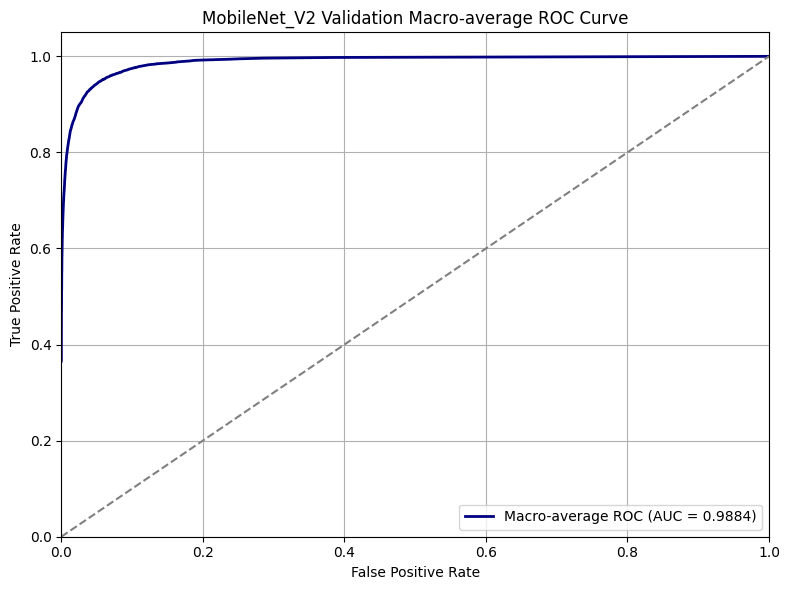

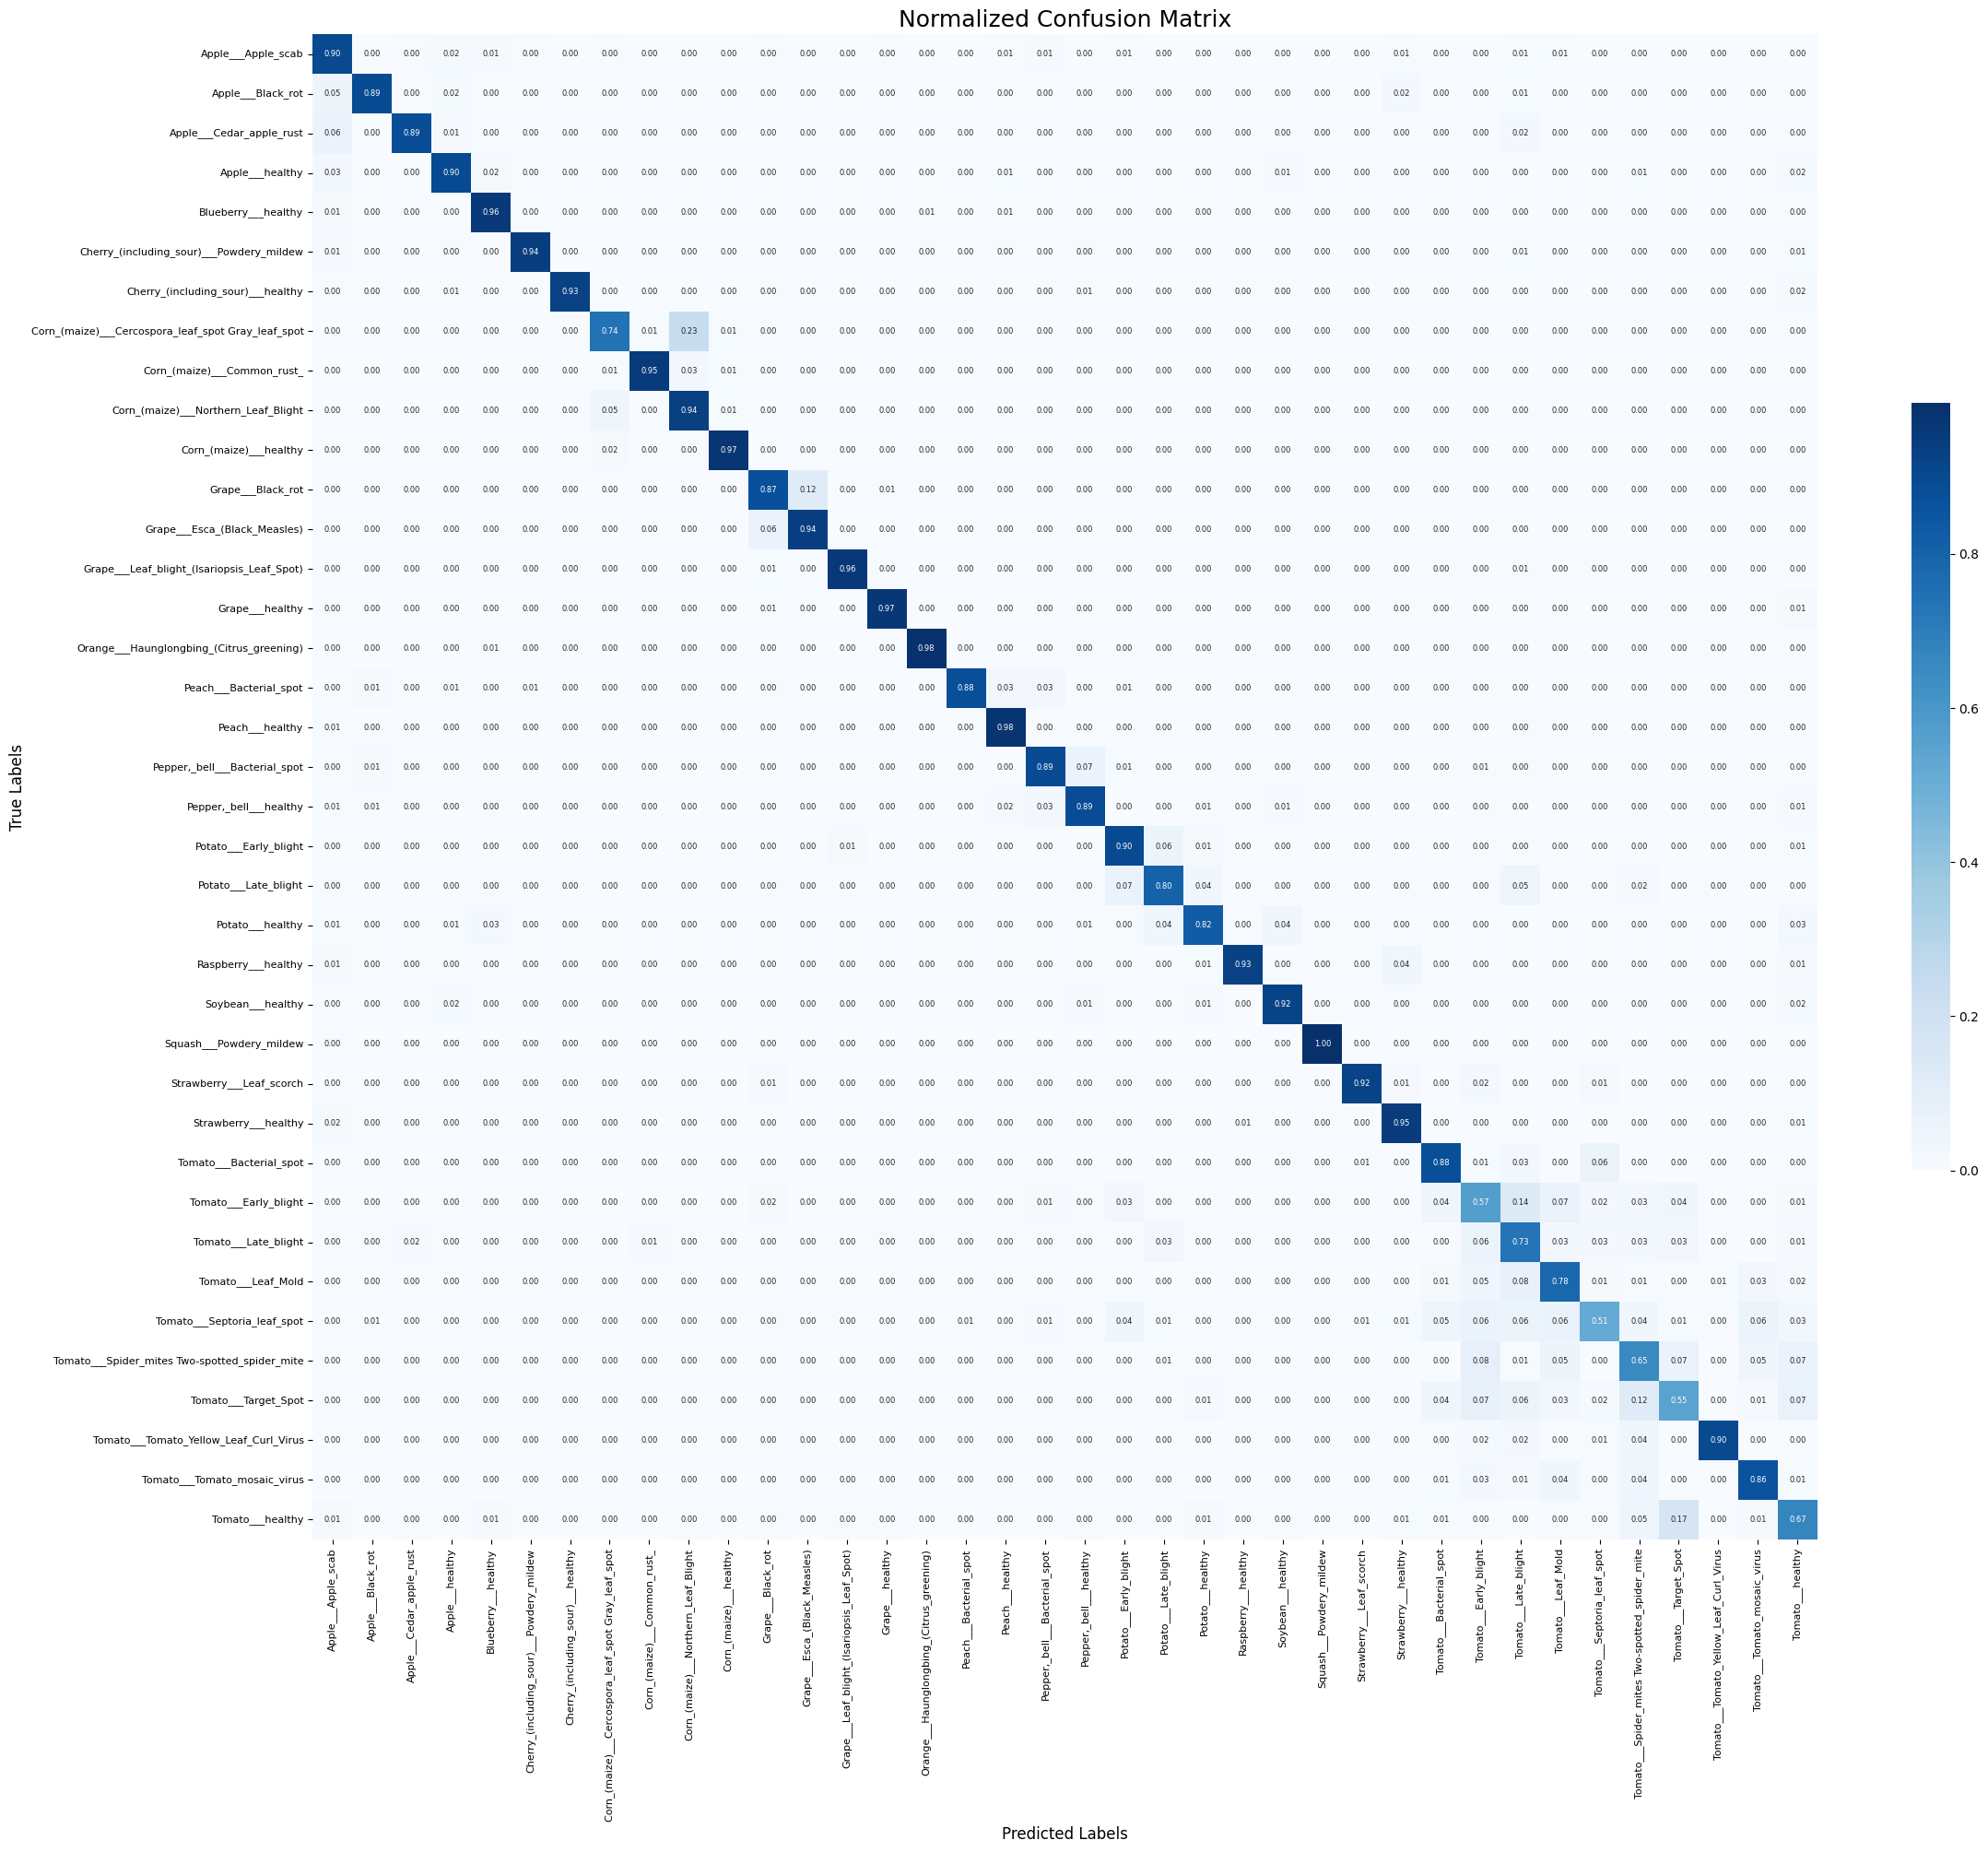

In [21]:
eval_mdl(y_true = val_y_true, y_pred = val_y_pred, y_prob = val_y_probs,class_names = class_names,label = "MobileNet_V2 Validation",normalize = True)

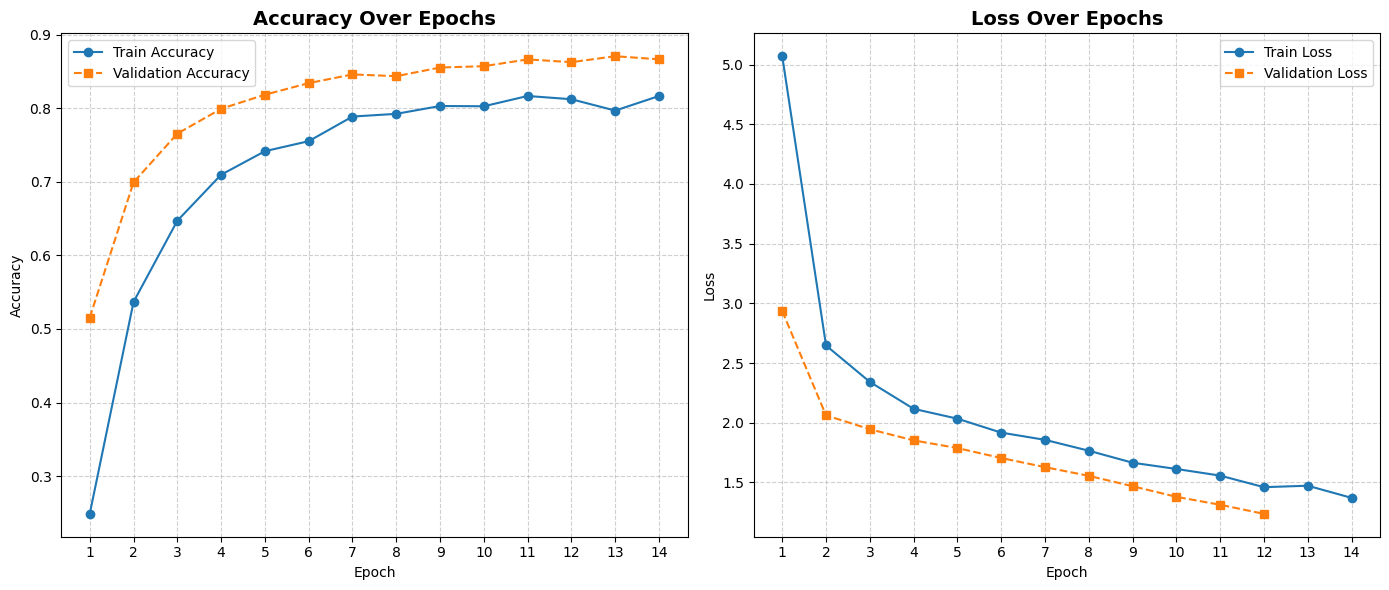

In [22]:
plt_acc_and_lss_crvs(hisx)

In [23]:
# Example
tst_y_true = tst_dta.classes  # From generator
tst_y_probs = mbnet_mdlx.predict(tst_dta, verbose=1)
tst_y_pred = npx.argmax(tst_y_probs, axis=1)

# Class names (as you already have)
tst_class_names = list(tst_dta.class_indices.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



550/550 ━━━━━━━━━━━━━━━━━━━━ 147s 267ms/step



MobileNet_V2 Testing Metrics:
Accuracy            : 0.8739
F1 Score (Weighted) : 0.8739
Precision           : 0.8793
Recall              : 0.8739
Cohen's Kappa       : 0.8705

MobileNet_V2 Testing Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.78      0.86      0.82       252
                                 Apple___Black_rot       0.90      0.92      0.91       249
                          Apple___Cedar_apple_rust       0.98      0.86      0.92       220
                                   Apple___healthy       0.91      0.86      0.89       251
                               Blueberry___healthy       0.96      0.97      0.97       227
          Cherry_(including_sour)___Powdery_mildew       0.96      0.98      0.97       211
                 Cherry_(including_sour)___healthy       0.99      0.95      0.97       228
Corn_(maize)___Cercospora_leaf_spot Gray_

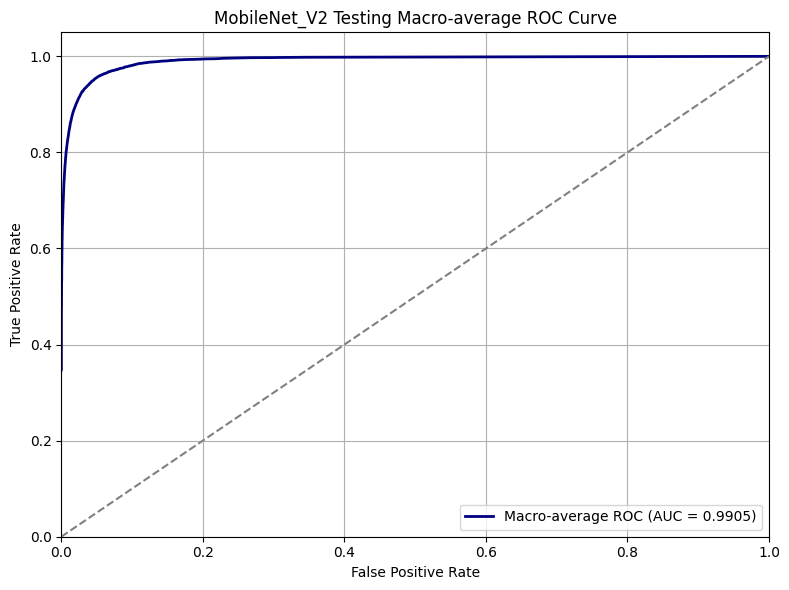

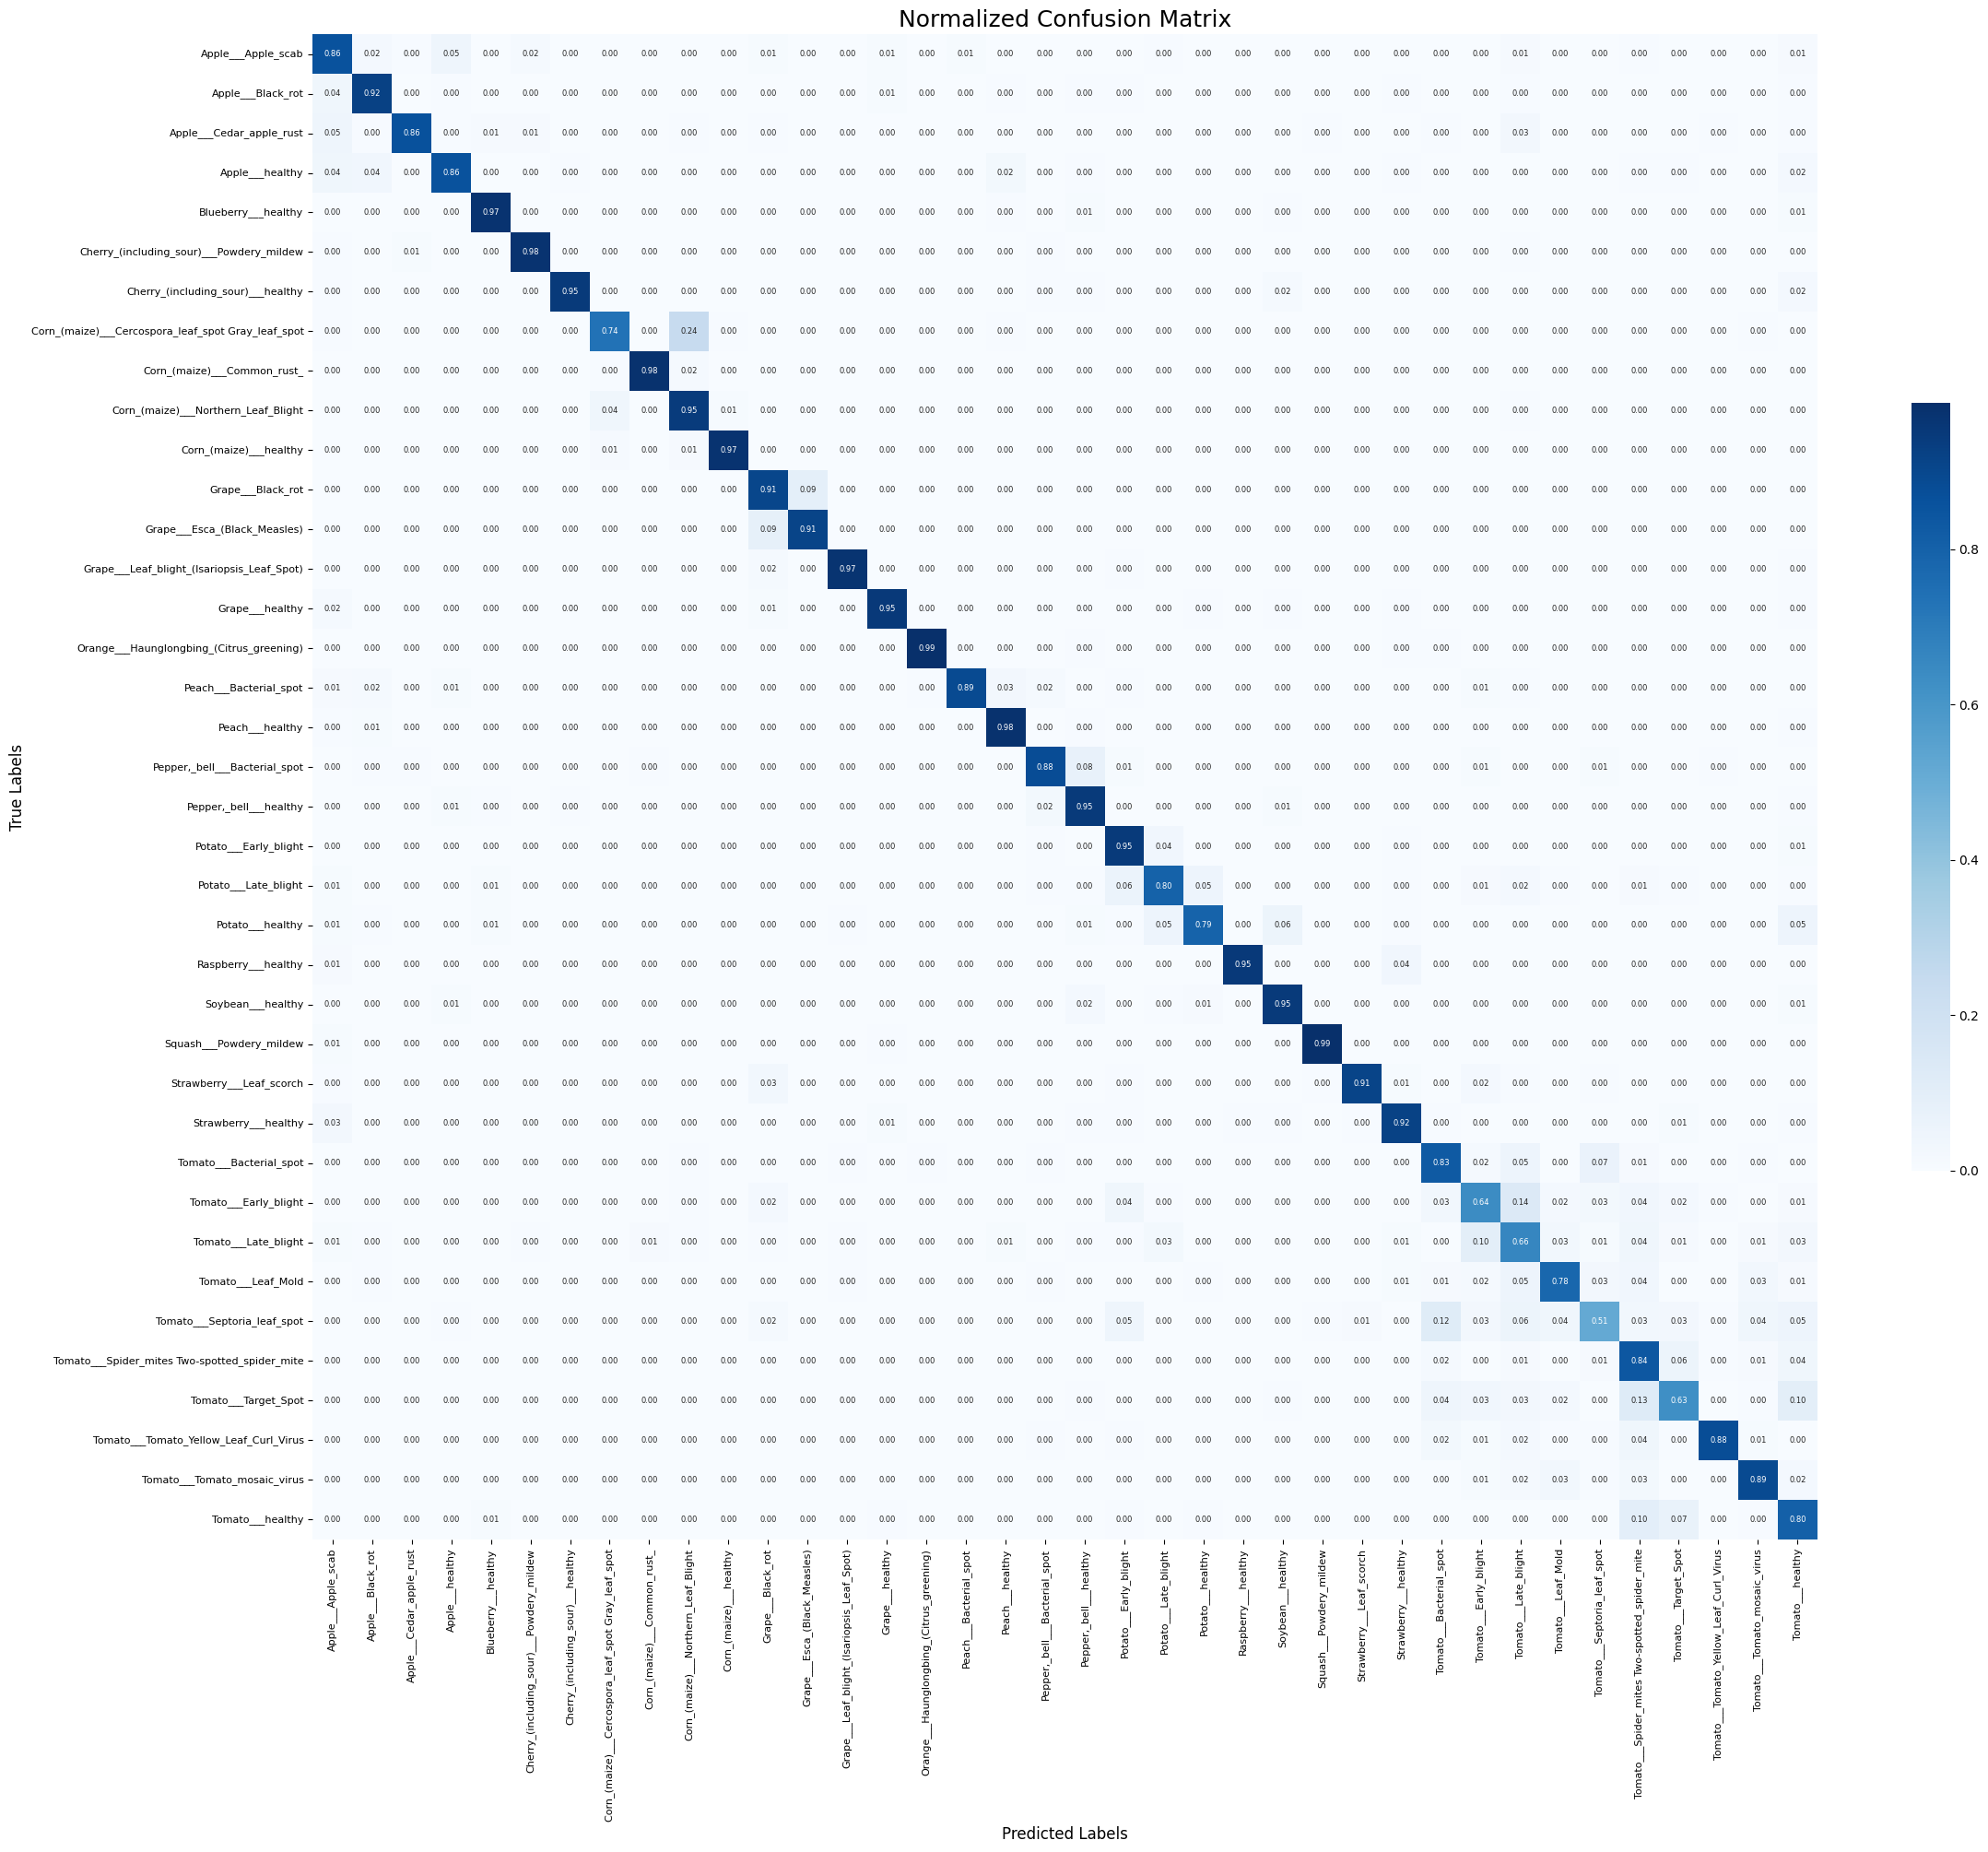

In [24]:
eval_mdl(y_true = tst_y_true, y_pred = tst_y_pred, y_prob = tst_y_probs,class_names = tst_class_names,label = "MobileNet_V2 Testing",normalize = True)

# **Inference**

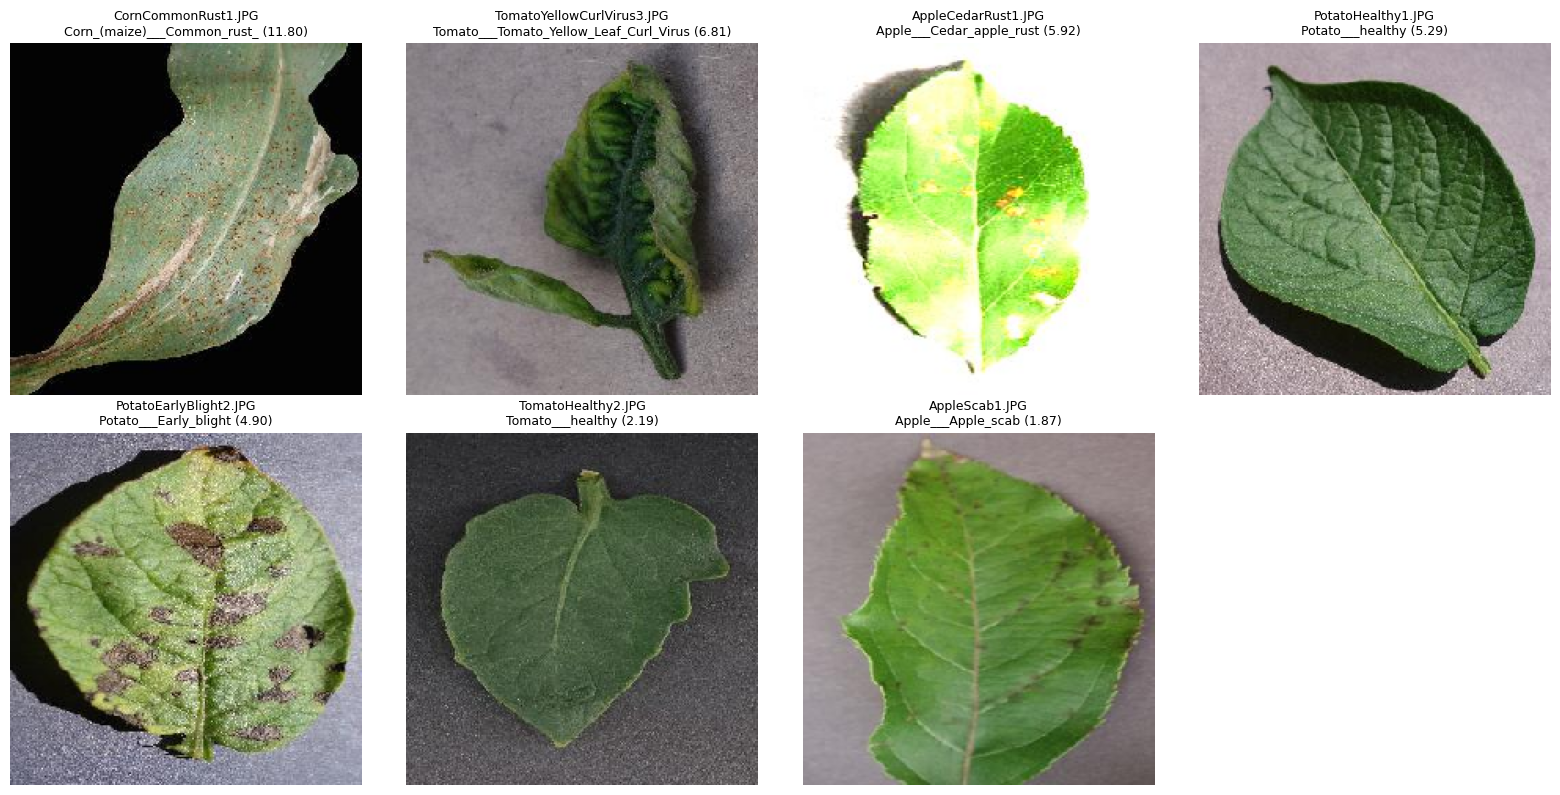

In [71]:
with open(config.mbnet_categories, 'r') as f:
    class_indices = json.load(f)
    
img_lst = [
    "/kaggle/input/new-plant-diseases-dataset/test/test/AppleCedarRust1.JPG",
    "/kaggle/input/new-plant-diseases-dataset/test/test/AppleScab1.JPG",
    "/kaggle/input/new-plant-diseases-dataset/test/test/CornCommonRust1.JPG",
    "/kaggle/input/new-plant-diseases-dataset/test/test/PotatoEarlyBlight2.JPG",
    "/kaggle/input/new-plant-diseases-dataset/test/test/PotatoHealthy1.JPG",
    "/kaggle/input/new-plant-diseases-dataset/test/test/TomatoHealthy2.JPG",
    "/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus3.JPG"
    
]

inferr(
    model=mbnet_mdlx,
    img_paths=img_lst,  # your list of full paths
    class_indices=class_indices,
    imgs_per_row=4
)

